# Лабораторная работа №2

Требования:
* Python >= 3.X
* NLTK >= 3.2.5

Лабораторную работу необходимо выполнять в данном шаблоне. Результат работы выслать письмом на litvinov.vg@ssau.ru. В теме письма указывать ФИО полностью.

Необходимо провести исследование различных способов представления документов и их влияние на качество определения тональности.

В качестве входных данных к лабораторной работе взят широко известный набор данных IMDB, содержащий 50K обзоров фильмов ([imdb-dataset-of-50k-movie-reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)). Откликами являются значения двух классов positive и negative.

In [26]:
import nltk
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.util import ngrams

import re
import nltk

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup

### Шаг 1. Подготовка данных

В качестве исследуемых способов представления необходимо рассмотреть:
#### 1. Bag of words: word counts ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)). Компоненты вектора: частоты или относительные частоты.

In [3]:
data = pd.read_csv("../data/IMDB Dataset.csv")
print(len(data))
data.head()

50000


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [11]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['review'])
X.shape

(50000, 101895)

#### 2. Bag of words: weird numbers ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)). Компоненты вектора: оценки "значимости" слова (например tf-idf).

In [4]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['review'])
X.shape

(50000, 101895)

#### 3. Bag of ngrams. Позволяет учитывать положение слов. Компоненты вектора: частоты N-грам. Примитивный подход, но в некоторых задачах он может улучшать качество решения.

In [10]:
def get_ngrams(text, n):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

bigramms = get_ngrams(' '.join(data['review'].values), 2)
bigramms[:10]

['One of',
 'of the',
 'the other',
 'other reviewers',
 'reviewers has',
 'has mentioned',
 'mentioned that',
 'that after',
 'after watching',
 'watching just']

In [12]:
def strip_html(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()


def remove_punctuations(text):
    punctuations = re.compile(r'[^\w\s]')
    text = punctuations.sub(r'',text)
    return text

In [13]:
stopwrds = stopwords.words('english')

def remove_stopwords(text):
    final_text =[]
    for i in text.split():
        #print(i.strip().lower())
        if i.strip().lower() not in stopwrds and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
            
    return " ".join(final_text)

In [20]:
data['review'] = data['review'].apply(strip_html)
data['review'] = data['review'].apply(remove_punctuations)
data['review'] = data['review'].apply(remove_stopwords)

In [21]:
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])
data.head()

review  sentiment
0  one reviewers mentioned watching oz episode yo...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically theres family little boy jake thinks...          0
4  petter matteis love time money visually stunni...          1

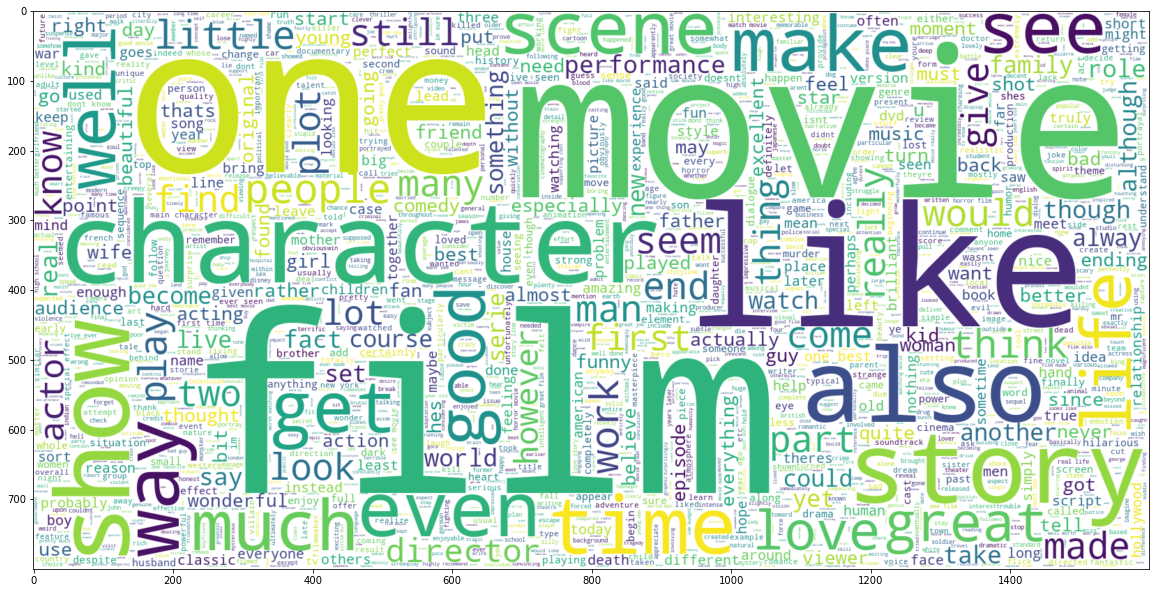

In [23]:
plt.figure(figsize = (20,20))
wrdcld = WordCloud(max_words=2000,width=1600, height=800,
                   stopwords=stopwrds, background_color='white').generate("".join(data[data['sentiment']==1].review))

plt.imshow(wrdcld, interpolation='bilinear')

In [24]:
plt.figure(figsize = (20,20))
wrdcld = WordCloud(max_words=2000,width=1600, height =800,
                   stopwords = stopwrds,background_color='white').generate("".join(data[data['sentiment']==0].review))

plt.imshow(wrdcld,interpolation = 'bilinear')

In [27]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
count_vec = CountVectorizer()
countvec_train = count_vec.fit_transform(X_train)
countvec_test = count_vec.transform(X_test)

In [29]:
tfidf_vec = TfidfVectorizer()
tfidfvec_train = tfidf_vec.fit_transform(X_train)
tfidfvec_test = tfidf_vec.transform(X_test)

In [62]:
def report(estimator, x_test, y_test):
    predict = estimator.predict(x_test)
    print("Classification Report: \n", classification_report(y_test, predict, target_names=['Negative','Positive']))
    print("Confusion Matrix: \n", confusion_matrix(y_test, predict))
    print("Accuracy: \n", accuracy_score(y_test, predict))

### Шаг 2. Исследование моделей

В зависимости от способа представления оценить качество классификации как долю правильных ответов на выборке (accuracy). Не забывайте использовать перекрестную проверку ([cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)).

Для каждого из нижеперечисленных моделей необходимо определить оптимальные гиперпараметры ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))

Качество классификации оцениваем для следующих моделей:

#### 1. Машина опорных векторов ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

In [35]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

##### Count vectorizer

In [57]:
parameters = {'C':[1, 5, 10]}
linear_svc = LinearSVC(random_state=2022)
cv = KFold(n_splits=5, shuffle=True, random_state=2022)

svm_clf_count = GridSearchCV(linear_svc, parameters, cv=cv)
svm_clf_count.fit(countvec_train, y_train)

c:\users\aleksandr_fida\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=LinearSVC(random_state=2022),
             param_grid={'C': [1, 5, 10]})

In [63]:
report(svm_clf_count.best_estimator_, countvec_test, y_test)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      7550
    Positive       0.86      0.87      0.87      7450

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

Confusion Matrix: 
 [[6529 1021]
 [ 949 6501]]
Accuracy: 
 0.8686666666666667


##### TF-iDF

In [64]:
parameters = {'C':[1, 5, 10]}
linear_svc = LinearSVC(random_state=2022)
cv = KFold(n_splits=5, shuffle=True, random_state=2022)

svm_clf_tfidf = GridSearchCV(linear_svc, parameters, cv=cv)
svm_clf_tfidf.fit(tfidfvec_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=LinearSVC(random_state=2022),
             param_grid={'C': [1, 5, 10]})

In [65]:
report(svm_clf_tfidf.best_estimator_, tfidfvec_test, y_test)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      7550
    Positive       0.89      0.91      0.90      7450

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

Confusion Matrix: 
 [[6738  812]
 [ 704 6746]]
Accuracy: 
 0.8989333333333334


#### 2. Случайный лес ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [66]:
from sklearn.ensemble import RandomForestClassifier

##### Count vectorizer

In [67]:
parameters = {'n_estimators': [5, 10, 50]}
forest = RandomForestClassifier(random_state=2022)
cv = KFold(n_splits=5, shuffle=True, random_state=2022)

forest_clf_count = GridSearchCV(forest, parameters, cv=cv)
forest_clf_count.fit(countvec_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=RandomForestClassifier(random_state=2022),
             param_grid={'n_estimators': [5, 10, 50]})

In [68]:
report(forest_clf_count.best_estimator_, countvec_test, y_test)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.83      0.85      0.84      7550
    Positive       0.85      0.83      0.84      7450

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000

Confusion Matrix: 
 [[6453 1097]
 [1285 6165]]
Accuracy: 
 0.8412


##### TF-iDF

In [69]:
parameters = {'n_estimators': [5, 10, 50]}
forest = RandomForestClassifier(random_state=2022)
cv = KFold(n_splits=5, shuffle=True, random_state=2022)

forest_clf_tfidf = GridSearchCV(forest, parameters, cv=cv)
forest_clf_tfidf.fit(tfidfvec_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=RandomForestClassifier(random_state=2022),
             param_grid={'n_estimators': [5, 10, 50]})

In [70]:
report(forest_clf_tfidf.best_estimator_, tfidfvec_test, y_test)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.83      0.85      0.84      7550
    Positive       0.85      0.82      0.83      7450

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000

Confusion Matrix: 
 [[6444 1106]
 [1349 6101]]
Accuracy: 
 0.8363333333333334


### Шаг 3. Сравнение результатов

Сравнить точность обученных моделей. Найти наиболее точную.

In [71]:
report(svm_clf_count.best_estimator_, countvec_test, y_test)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      7550
    Positive       0.86      0.87      0.87      7450

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

Confusion Matrix: 
 [[6529 1021]
 [ 949 6501]]
Accuracy: 
 0.8686666666666667


In [72]:
report(svm_clf_tfidf.best_estimator_, tfidfvec_test, y_test)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      7550
    Positive       0.89      0.91      0.90      7450

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

Confusion Matrix: 
 [[6738  812]
 [ 704 6746]]
Accuracy: 
 0.8989333333333334


In [73]:
report(forest_clf_count.best_estimator_, countvec_test, y_test)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.83      0.85      0.84      7550
    Positive       0.85      0.83      0.84      7450

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000

Confusion Matrix: 
 [[6453 1097]
 [1285 6165]]
Accuracy: 
 0.8412


In [74]:
report(forest_clf_tfidf.best_estimator_, tfidfvec_test, y_test)

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.83      0.85      0.84      7550
    Positive       0.85      0.82      0.83      7450

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000

Confusion Matrix: 
 [[6444 1106]
 [1349 6101]]
Accuracy: 
 0.8363333333333334


### Вывод

Наибольшее значение Accuracy показал SVM классификатор с TF-iDF препроцессингом